### Hey, guys. In this notebook, I will do some spam message detection.
> Table of Content:
1. [Part 1: Exploratory Data Analysis](#part1)
2. [Part 2: Vectorize the Text](#part2)
3. [Part 3: Build ML Model and Evaluate](#part3)
4. [Part 4: Build LSTM/RoBERTa](#part4)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import collections
import string
import re
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM, SVC
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score, \
classification_report, RocCurveDisplay, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from transformers import AdamWeightDecay

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a id='part1'></a>
## Part 1: Exploratory Data Analysis

**This is a dataset with anomalies. To begin, let's first examine the proportion of anomalies.**

In [2]:
df = pd.read_csv('/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv')
df['Category_num'] = pd.get_dummies(df['Category'], drop_first=True, dtype=int)
print(df.shape)
df.head()

(5572, 3)


,Category,Message,Category_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


**We can find the spam data proportion is only 13%.**

Category
ham     4825
spam     747
Name: count, dtype: int64
0.13406317300789664


<Axes: xlabel='Category', ylabel='count'>

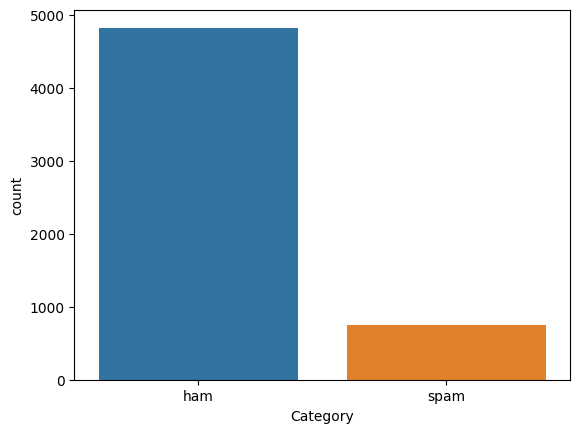

In [3]:
print(df['Category'].value_counts())
print(len(df[df['Category'] == 'spam'])/len(df))
sns.countplot(df, x='Category')

**Next, I will tokenize the text and calculate the vocabulary size.**

In [4]:
nltk.download('punkt')
def word_cut(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    texts = word_tokenize(text)
    words = [word for word in texts if word not in string.punctuation and word not in stopwords.words('english')]
    return words
df['Message_cut'] = df['Message'].apply(word_cut)
df['Message_count'] = df['Message_cut'].apply(lambda x: len(x))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**We can now examine the distribution of ham and spam messages based on vocabulary size.**  

**It appears that the vocabulary size for spam messages is relatively concentrated and not very extensive.**

<Axes: xlabel='Category', ylabel='Message_count'>

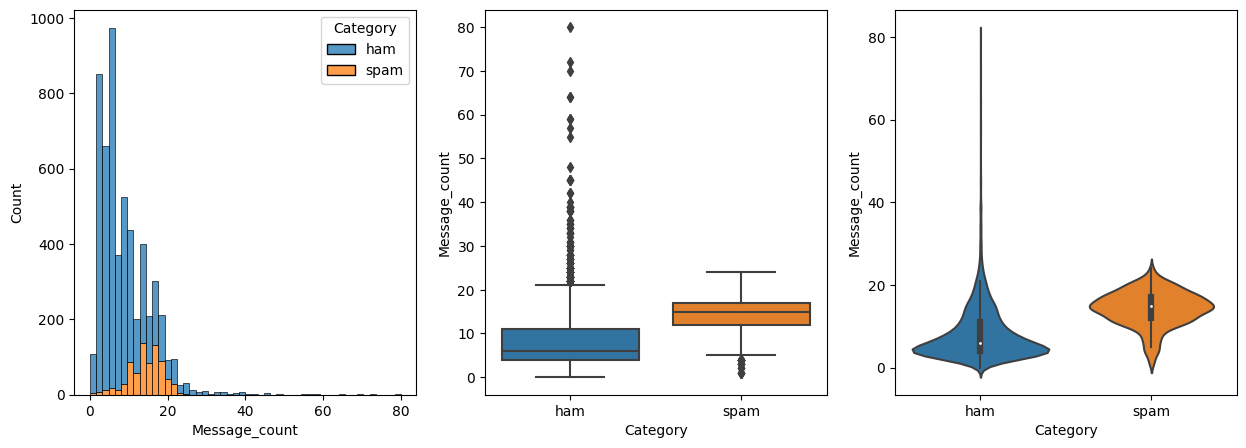

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
sns.histplot(df, x='Message_count', hue='Category', multiple='stack', bins=50)

plt.subplot(1,3,2)
sns.boxplot(df, x='Category', y='Message_count')

plt.subplot(1,3,3)
sns.violinplot(df, x='Category', y='Message_count')

### Common word analysis: 
Examine the most frequently used words in "spam" and "ham" messages.

We find that the most words in spam messages is call and free. It could indicate that in spam messages, there are more references to calling or attempt to deceive people with promises of free service.

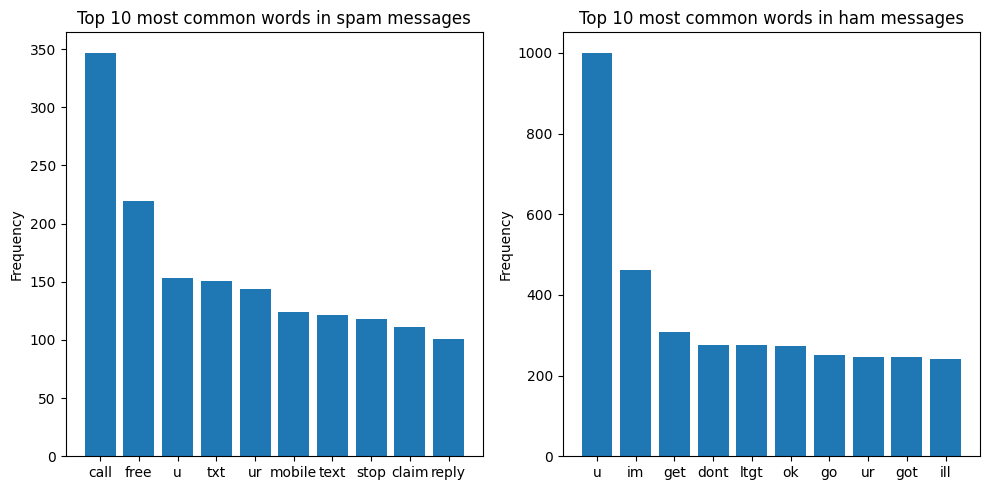

In [6]:
spam_words = [word for sublist in df[df['Category'] == 'spam']['Message_cut'].tolist() for word in sublist]
ham_words = [word for sublist in df[df['Category'] == 'ham']['Message_cut'].tolist() for word in sublist]

# counter the words for top 10
top_spam_words = collections.Counter(spam_words).most_common(10)
top_ham_words = collections.Counter(ham_words).most_common(10)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.bar(*zip(*top_spam_words))
plt.title('Top 10 most common words in spam messages')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.bar(*zip(*top_ham_words))
plt.title('Top 10 most common words in ham messages')
plt.ylabel('Frequency')

plt.tight_layout()

<a id='part2'></a>
## Part 2: Vectorize the Text
Vectorize the text using a pretrained Word2Vec model.

In [5]:
model_path = '/kaggle/input/googlenews-vectors-negative300bingz-gz-format/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [7]:
print(word2vec.most_similar(positive=['king','old'], negative=['young','woman'], topn=5))
print(len(word2vec['king']))

[('undisputed_king', 0.3576328754425049), ('kings', 0.3485284447669983), ('Critics_derisively_nicknamed', 0.32486337423324585), ('ruler', 0.32204580307006836), ('Shah_dynasty', 0.3197304308414459)]
300


In [8]:
df['Message_cut']

0       [go, jurong, point, crazy, available, bugis, n...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, wkly, comp, win, fa, cup, final,...
3           [u, dun, say, early, hor, u, c, already, say]
4       [nah, dont, think, goes, usf, lives, around, t...
                              ...                        
5567    [nd, time, tried, contact, u, u, pound, prize,...
5568                      [b, going, esplanade, fr, home]
5569                     [pity, mood, soany, suggestions]
5570    [guy, bitching, acted, like, id, interested, b...
5571                                   [rofl, true, name]
Name: Message_cut, Length: 5572, dtype: object

In [8]:
# calculate TFIDF score
def fake_tokenize(text):
    return text
def fake_preprocess(text):
    return text

tv = TfidfVectorizer(tokenizer=fake_tokenize, preprocessor=fake_preprocess)
tv_matrix = tv.fit_transform(df['Message_cut'])
feature_names = tv.get_feature_names_out()

In [9]:
def get_weight_vector(text, tv_vector, feature_names, word2vec):
    text_vector = np.zeros((len(text), word2vec.vector_size)) # (16, 300)
    weights = np.zeros(len(text)) # (16,)
    for i, word in enumerate(text):
        try:
            text_vector[i,:] = word2vec[word]
            indices = np.where(feature_names == word)[0] # (array([8224]),) --> array([8224])
            weights[i] = tv_vector[0,indices[0]] if indices.size > 0 else 0
        except KeyError:
            pass
    if np.sum(weights) != 0:
        weighted_vector = np.dot(weights, text_vector) / np.sum(weights) # (300,)
    else:
        weighted_vector = np.zeros(word2vec.vector_size)
    return weighted_vector

In [10]:
all_text_vectors = []
for i in range(tv_matrix.shape[0]):
    tv_vector = tv_matrix[i, :]
    text = df['Message_cut'].iloc[i]
    weighted_vector = get_weight_vector(text, tv_vector, feature_names, word2vec)
    all_text_vectors.append(weighted_vector)

<a id='part3'></a>
## Part 3: Build Model and Evaluate
Following that, we can utilize the pre-weighted vectors for various machine learning tasks.  
Since it's imbalanced data, we evaluate the model with AUC curve and precision-recall curve.

In [8]:
X = all_text_vectors
y = df['Category_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy: 0.8825112107623319

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       966
           1       0.55      0.68      0.61       149

    accuracy                           0.88      1115
   macro avg       0.75      0.80      0.77      1115
weighted avg       0.90      0.88      0.89      1115

AUC score 0.7959655119707644


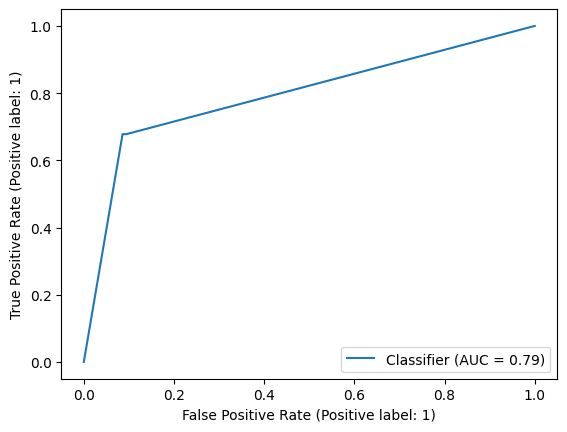

In [26]:
# build Decisoin Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("AUC score", roc_auc_score(y_test, y_pred))
RocCurveDisplay.from_predictions(y_test, y_prob)

Accuracy: 0.9659192825112107

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.75      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115

AUC score 0.8753213278308114


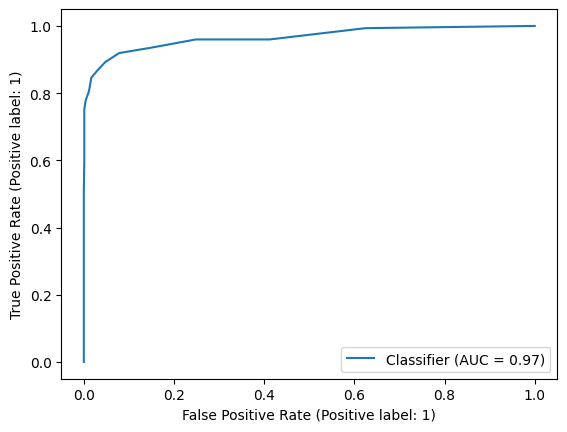

In [34]:
# build RandomForest model
rfc = RandomForestClassifier(n_estimators=20, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_prob = rfc.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("AUC score", roc_auc_score(y_test, y_pred))
RocCurveDisplay.from_predictions(y_test, y_prob)

Accuracy: 0.9766816143497757

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.97      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.97      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

AUC score 0.9241041032695542


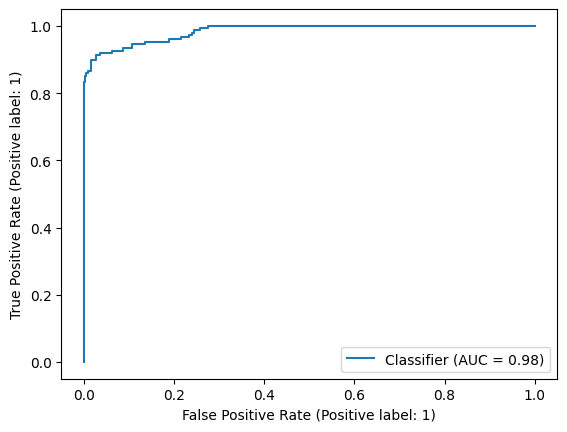

In [31]:
# build SVM model
svc = SVC(probability=True, random_state=42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_prob = svc.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("AUC score", roc_auc_score(y_test, y_pred))
RocCurveDisplay.from_predictions(y_test, y_prob)

In [46]:
# build catboost model
cat = CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.03, loss_function='Logloss', verbose=200)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("AUC score", roc_auc_score(y_test, y_pred))

0:	learn: 0.6574690	total: 448ms	remaining: 7m 27s
200:	learn: 0.0297042	total: 1m 29s	remaining: 5m 55s
400:	learn: 0.0103188	total: 2m 56s	remaining: 4m 23s
600:	learn: 0.0059661	total: 4m 22s	remaining: 2m 54s
800:	learn: 0.0043385	total: 5m 48s	remaining: 1m 26s
999:	learn: 0.0035640	total: 7m 13s	remaining: 0us
Accuracy: 0.9757847533632287

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.97      0.85      0.90       149

    accuracy                           0.98      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.98      0.98      0.98      1115

AUC score 0.9207483985715675


In [45]:
# build LightGBM model
lgb = LGBMClassifier(n_estimators=1000, max_depth=-1, learning_rate=0.03, objective='binary', metric='auc')
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("AUC score", roc_auc_score(y_test, y_pred))

Accuracy: 0.979372197309417

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

AUC score 0.9313331110092127


<a id='part4'><a/>
## Part 4: Build LSTM/RoBERTa
Due to the textual nature of our data, and the fact that sentences have context, I will proceed to build models using LSTM and RoBERTa. 

In [6]:
def word_to_vector(text):
    word = [word2vec[word] for word in text if word in word2vec]
    return word
df['Message_vector'] = df['Message_cut'].apply(word_to_vector)
padded_text = pad_sequences(df['Message_vector'].tolist(), padding='post', dtype='float32')

# split data
X_train, X_test, y_train, y_test = train_test_split(padded_text, y, test_size=0.2, random_state=42)

In [18]:
X_test.shape

(1115, 69, 300)

In [13]:
# build LSTM model

model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=20)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=0)

<Axes: >

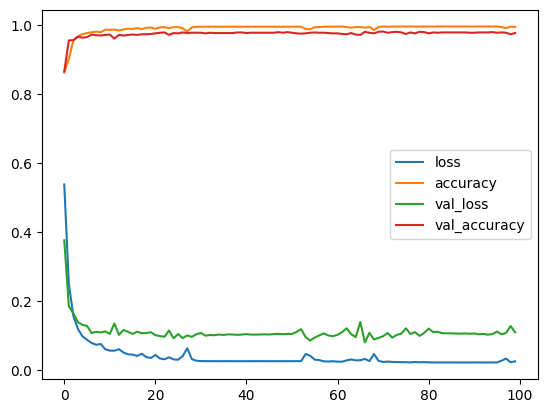

In [14]:
pd.DataFrame(model.history.history).plot()

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)

35/35 [==============================] - 0s 4ms/step - loss: 0.1099 - accuracy: 0.9776


In [16]:
y_prob = model.predict(X_test).ravel()

35/35 [==============================] - 0s 3ms/step


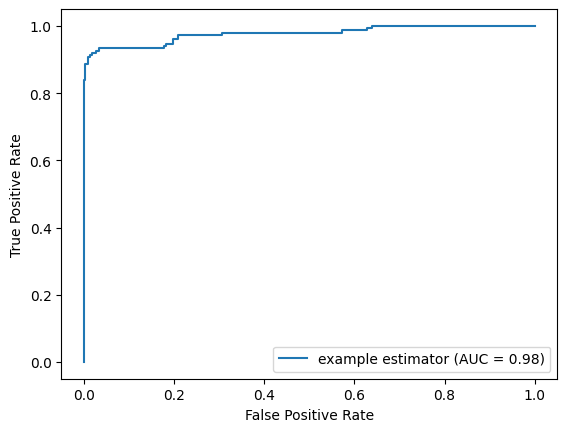

In [17]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()

**This approach involves preprocessing the entire dataset before splitting it into training and testing sets.**

In [28]:
# build RoBERTa model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_length = int(df['Message'].apply(len).quantile(0.9))
input_dict = tokenizer(df['Message'].tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='tf')
labels = convert_to_tensor(df['Category_num'].values)
# convert to numpy
input_ids_np = input_dict['input_ids'].numpy()
attention_mask_np = input_dict['attention_mask'].numpy()
labels_np = labels.numpy()

# with train test split
train_inputs_ids, test_inputs_ids, train_attention_mask, test_attention_mask, train_labels, test_labels = train_test_split(
    input_ids_np, attention_mask_np, labels_np, test_size=0.2, random_state=42, stratify=labels_np)

# numpy to tensor
train_inputs_ids_tf = tf.constant(train_inputs_ids)
test_inputs_ids_tf = tf.constant(test_inputs_ids)
train_attention_mask_tf = tf.constant(train_attention_mask)
test_attention_mask_tf = tf.constant(test_attention_mask)
train_labels_tf = tf.constant(train_labels)
test_labels_tf = tf.constant(test_labels)

In [29]:
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

optimizer = Adam(learning_rate=0.00001)
loss = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

model.fit([train_inputs_ids_tf, train_attention_mask_tf], train_labels_tf,
         validation_data=([test_inputs_ids_tf, test_attention_mask_tf], test_labels_tf),
         epochs=3, batch_size=32, verbose=1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3
140/140 [==============================] - 150s 726ms/step - loss: 0.1563 - accuracy: 0.9455 - val_loss: 0.0283 - val_accuracy: 0.9901
Epoch 2/3
140/140 [==============================] - 93s 668ms/step - loss: 0.0178 - accuracy: 0.9953 - val_loss: 0.0249 - val_accuracy: 0.9919
Epoch 3/3
140/140 [==============================] - 94s 669ms/step - loss: 0.0078 - accuracy: 0.9982 - val_loss: 0.0225 - val_accuracy: 0.9937


In [51]:
output = model.predict([test_inputs_ids_tf, test_attention_mask_tf])

35/35 [==============================] - 7s 207ms/step


In [52]:
logits = output.logits
prob = tf.nn.softmax(logits, axis=-1)
y_prob = prob[:,1].numpy()

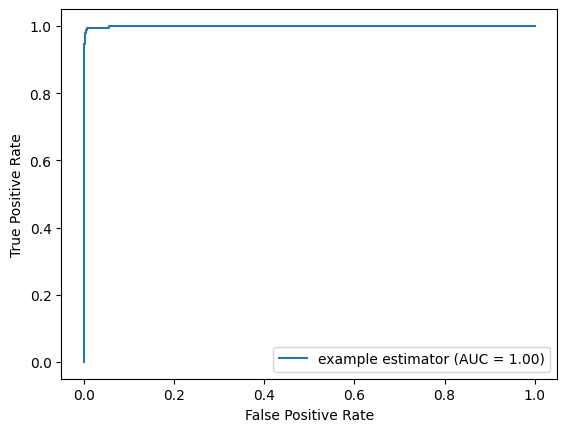

In [53]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(test_labels, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()

**But, I use a different approach where I split the data first and then perform data transformation to reduce efficiency issues.**

In [44]:
# build RoBERTa model
train_text, test_text, train_label, test_label = train_test_split(df['Message'].values, df['Category_num'].values, test_size=0.2,
                                                                 random_state=42, stratify=df['Category_num'].values)
# tokenization
max_length = int(df['Message'].apply(len).quantile(0.9))
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_tokenize = tokenizer(train_text.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_tokenize = tokenizer(test_text.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# to tensor
train_label = tf.convert_to_tensor(train_label, dtype=tf.float32)
test_label = tf.convert_to_tensor(test_label, dtype=tf.float32)

# compile model
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)
optimizer = Adam(learning_rate=0.00001)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', AUC(name='auc')])

model.fit([train_tokenize['input_ids'], train_tokenize['attention_mask']], train_label,
          validation_data=([test_tokenize['input_ids'], test_tokenize['attention_mask']], test_label),  epochs=5, batch_size=32)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/5
140/140 [==============================] - 150s 741ms/step - loss: 0.1760 - accuracy: 0.9329 - auc: 0.7856 - val_loss: 0.0385 - val_accuracy: 0.9910 - val_auc: 0.9693
Epoch 2/5
140/140 [==============================] - 94s 668ms/step - loss: 0.0291 - accuracy: 0.9924 - auc: 0.9815 - val_loss: 0.0310 - val_accuracy: 0.9910 - val_auc: 0.9755
Epoch 3/5
140/140 [==============================] - 90s 643ms/step - loss: 0.0170 - accuracy: 0.9960 - auc: 0.9872 - val_loss: 0.0354 - val_accuracy: 0.9919 - val_auc: 0.9755
Epoch 4/5
140/140 [==============================] - 93s 664ms/step - loss: 0.0102 - accuracy: 0.9973 - auc: 0.9931 - val_loss: 0.0197 - val_accuracy: 0.9937 - val_auc: 0.9827
Epoch 5/5
140/140 [==============================] - 93s 664ms/step - loss: 0.0032 - accuracy: 0.9991 - auc: 0.9982 - val_loss: 0.0366 - val_accuracy: 0.9919 - val_auc: 0.9755


<Axes: >

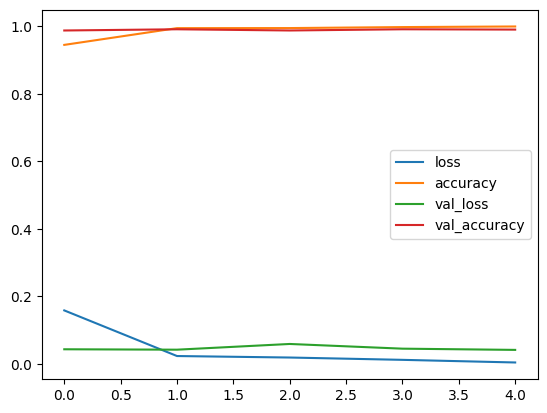

In [8]:
pd.DataFrame(model.history.history).plot()

35/35 [==============================] - 7s 208ms/step
AUC Score: 0.999187127433407


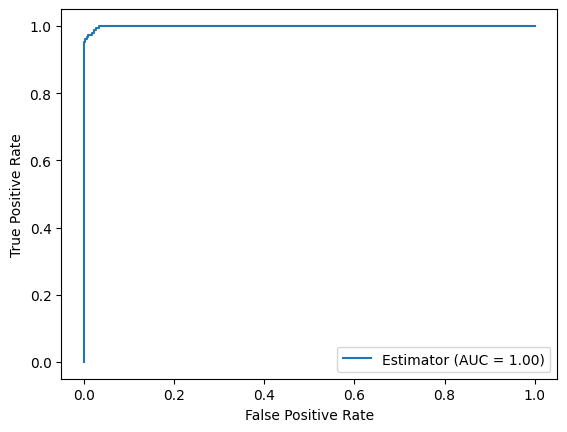

In [49]:
test_pred = model.predict([test_tokenize['input_ids'], test_tokenize['attention_mask']])
test_pred = tf.sigmoid(test_pred.logits).numpy()

# AUC score
auc_score = roc_auc_score(test_label.numpy(), test_pred)
print(f'AUC Score: {auc_score}')

# Plot the ROC curve
fpr, tpr, _ = roc_curve(test_label.numpy(), test_pred)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score, estimator_name='Estimator')
display.plot()


**Let's predict some sentence.**

In [73]:
# initializer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
sentence = "Please call me. #1231131 if you are interested in this investment, don't worry, It's free!!"
#sentence = "It's free!! Click the link and you can get 10000 dollars!!"
#sentence = "This is a book"
print(f"This is our message {sentence}")
# encoding
encoding = tokenizer(sentence, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

text_pred = model.predict([encoding['input_ids'], encoding['attention_mask']], verbose=0)
text_pred = text_pred.logits
text_pred = tf.sigmoid(text_pred).numpy()
print(f"The probability of this message is {text_pred[0][0]}")

# prediction
prediction = (text_pred > 0.5).astype(int)
if prediction[0][0] == 0:
    print("We predicted this message is ham message")
else:
    print("We predicted this message is spam message")


This is our message Please call me. #1231131 if you are interested in this investment, don't worry, It's free!!
The probability of this message is 0.9989456534385681
We predicted this message is spam message
